<!-- Customize the font and markdown size -->
# Custom RL Algorithm with EVsSimulator gym environment🚗🚗🔋🔋📉
---

This Notebook provides a simple example of how to develop your own custom RL environment using the OpenAI Gym interface. We will use the **simple configuration of EVsSimulator** for the power *setpoint tracking problem*. We will then train a simple DQN agent to solve the environment.


**Learning Objectives:**
- Familiarize with the OpenAI Gym interface
- Develop a DQN agent for a simple environment

### 1. Creating the Environment 🚗

- EVsSimulator simulates a Charge Point Operator (CPO) controlling a **fixed number of charging stations** scattered in a city where EVs that arrive and depart.

- The goal of the CPO is to **minimize the difference between the power setpoint and the actual power** consumed by the charging stations.

 - The CPO can control the current(**A**) of each port of each charging station. The current is limited by the **maximum current**(**I**) of the charging station and the **maximum current**(**I**) of the port.



Current directory: e:\GitHub\EVsSimulator\tutorials
Current directory: e:\GitHub\EVsSimulator


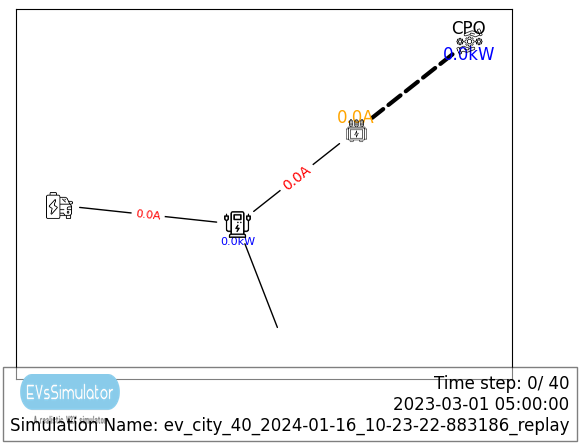

In [1]:
import sys
import os
import numpy as np
sys.path.append("..")
print("Current directory: " + os.getcwd())
#change directory   


os.chdir(os.getcwd() + "/..")
#print current_ directory
print("Current directory: " + os.getcwd())

from EVsSimulator import ev_city

# Create the environment
env = ev_city.EVCity(config_file="config_files/config_tutorial_1.yaml", 
                     load_from_replay_path="replay/replay_ev_city_40_2024-01-16_10-23-22-883186.pkl",
                     render_mode=True,
                     save_plots=False,
                     save_replay=False,
                     )


#### 1.1 Action Space
The ***action space*** is a vector of size **N** (total number of ports) where each element is a continuous value between **-1** and **1** representing the **percentage of the maximum current** that the CPO wants to set for each 
port.

Values from -1 to 0 represent discharging the EVs, 0 means no current, and values from 0 to 1 represent charging the EVs.


**Discretization**: For the needs of this example, we will discretize the action space into 10 discrete actions.

In [2]:
def discretize_action(action):

    if action == 0:
        return [0, 0]
    elif action == 1:
        return [0.5, 0]
    elif action == 2:
        return [1, 0]
    elif action == 3:
        return [0, 0.5]
    elif action == 4:
        return [0, 1]
    elif action == 5:
        return [0.5, 0.5]    
    else:
        raise ValueError("Invalid action: ", action)

#Give an example and let the students design with only small changes

#### 1.2 State Space

The ***state space*** provides information about the current state of the environment. Normaly the user has the option to configure the state space. In this case, the state space is a vector of size 

.....
.
.
.
.

In [3]:
#Get a random state
env.observation_space.sample()

array([-0.38990029, -0.12206177, -0.74488492,  2.19196594, -1.46653404,
        0.06655312,  1.5259582 ,  1.32962806,  0.01849721, -0.58528644,
        0.078275  ,  0.18366057,  3.17500663])

#### 1.3 Reward Function

The ***reward function*** is a function that returns a reward value based on the current state of the environment. The reward function is used by the agent to learn how to behave in the environment. The reward function is defined by the user. In this case, the reward function is defined as:

$$
R(s_t,a_t,s_{t+1}) = \begin{cases}
    - (P^{setpoint} - P^{actual}) & \text{if $P^{setpoint} < P^{actual}$}.\\
    P^{actual}/75 & \text{otherwise}.
  \end{cases}
$$



Now your time:
Design a reward function that can be used to solve the environment ..

```python

## 2. Setting Up the DQN Agent 🤖
---

Here, we will develop a simple DQN agent to solve the environment.

Code based on the [DQN tutorial](https://pytorch.org/tutorials/intermediate/reinforcement_q_learning.html) from the PyTorch website.

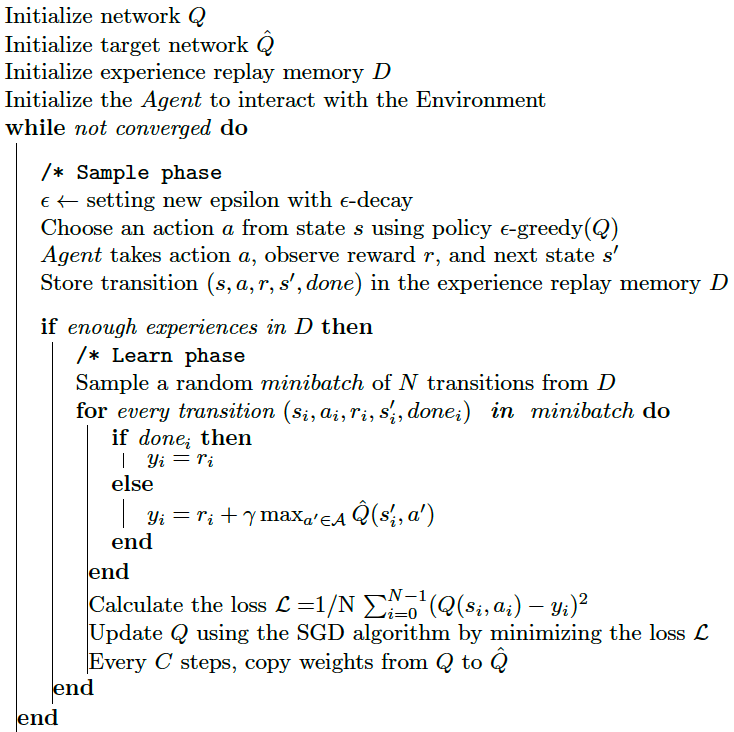

In [4]:
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F

import random
import math
from collections import namedtuple, deque
from itertools import count

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [5]:
Transition = namedtuple('Transition',
                        ('state', 'action', 'next_state', 'reward'))

class ReplayMemory(object):

    def __init__(self, capacity):
        self.memory = deque([], maxlen=capacity)

    def push(self, *args):
        """Save a transition"""
        self.memory.append(Transition(*args))

    def sample(self, batch_size):
        return random.sample(self.memory, batch_size)

    def __len__(self):
        return len(self.memory)

##### Q-network

In [6]:
class Example_DQN(nn.Module):

    def __init__(self, n_observations, n_actions):
        super(DQN, self).__init__()
        self.layer1 = nn.Linear(n_observations, 128)
        self.layer2 = nn.Linear(128, 128)
        self.layer3 = nn.Linear(128, n_actions)

    def forward(self, x):
        x = F.relu(self.layer1(x))
        x = F.relu(self.layer2(x))
        return self.layer3(x)

Design Your own Q-network



class YourQNetwork(nn.Module):
    def __init__(self, state_dim, action_dim):
        super(YourQNetwork, self).__init__()
        self.fc1 = nn.Linear(state_dim, 64)
        <!-- Your code goes here -->
        self.fc3 = nn.Linear(64, action_dim)

    def forward(self, x):
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
        return x

#### Training

In an RL training process the agent interacts with the environment and learns from the experience. The agent's experience is stored in a replay memory. The agent samples a batch of experiences from the replay memory and learns from it. The goal is to maximize the expected reward.


In [7]:
# BATCH_SIZE is the number of transitions sampled from the replay buffer
# GAMMA is the discount factor as mentioned in the previous section
# EPS_START is the starting value of epsilon
# EPS_END is the final value of epsilon
# EPS_DECAY controls the rate of exponential decay of epsilon, higher means a slower decay
# TAU is the update rate of the target network
# LR is the learning rate of the ``AdamW`` optimizer
BATCH_SIZE = 64
GAMMA = 0.99
EPS_START = 0.9
EPS_END = 0.05
EPS_DECAY = 1000
TAU = 0.005
LR = 1e-4

# Get number of actions from gym action space
n_actions = 6 # we have 6 discrete actions
# Get the number of state observations
state = env.reset()
n_observations = len(state)

policy_net = DQN(n_observations, n_actions).to(device)
target_net = DQN(n_observations, n_actions).to(device)
target_net.load_state_dict(policy_net.state_dict())

optimizer = optim.AdamW(policy_net.parameters(), lr=LR, amsgrad=True)
memory = ReplayMemory(10000)

steps_done = 0


#### Exploration

The agent uses an $\epsilon$-greedy policy to explore the environment. The $\epsilon$-greedy policy selects a random action with probability $\epsilon$ and the action with the highest Q-value with probability $1-\epsilon$.


In [8]:
def select_action(state):
    global steps_done
    sample = random.random()
    eps_threshold = EPS_END + (EPS_START - EPS_END) * \
        math.exp(-1. * steps_done / EPS_DECAY)
    steps_done += 1
    if sample > eps_threshold:
        with torch.no_grad():
            # t.max(1) will return the largest column value of each row.
            # second column on max result is index of where max element was
            # found, so we pick action with the larger expected reward.
            return policy_net(state).max(1).indices.view(1, 1)
    else:
        return torch.tensor([[random.randint(0,n_actions-1)]], device=device, dtype=torch.long)

#### Update Neural Network

The neural network is updated using the DQN loss function:

$$
L = \frac{1}{N}\sum_i (y_i - Q(s_i, a_i))^2
$$

where $y_i$ is the target value and $Q(s_i, a_i)$ is the predicted value.

The target value is calculated as follows:

$$
y_i = r_i + \gamma \max_{a'} Q(s_{i+1}, a')

$$

where $r_i$ is the reward, $\gamma$ is the discount factor, and $s_{i+1}$ is the next state.

#### Target Network

The target network is used to calculate the target value. The weights of the target network are updated with the weights of the Q-network every $C$ steps.






In [9]:
def optimize_model():
    if len(memory) < BATCH_SIZE:
        return
    transitions = memory.sample(BATCH_SIZE)
    # Transpose the batch (see https://stackoverflow.com/a/19343/3343043 for
    # detailed explanation). This converts batch-array of Transitions
    # to Transition of batch-arrays.
    batch = Transition(*zip(*transitions))

    # Compute a mask of non-final states and concatenate the batch elements
    # (a final state would've been the one after which simulation ended)
    non_final_mask = torch.tensor(tuple(map(lambda s: s is not None,
                                          batch.next_state)), device=device, dtype=torch.bool)
    non_final_next_states = torch.cat([s for s in batch.next_state
                                                if s is not None])
    state_batch = torch.cat(batch.state)
    action_batch = torch.cat(batch.action)
    reward_batch = torch.cat(batch.reward)

    # Compute Q(s_t, a) - the model computes Q(s_t), then we select the
    # columns of actions taken. These are the actions which would've been taken
    # for each batch state according to policy_net
    state_action_values = policy_net(state_batch).gather(1, action_batch)

    # Compute V(s_{t+1}) for all next states.
    # Expected values of actions for non_final_next_states are computed based
    # on the "older" target_net; selecting their best reward with max(1).values
    # This is merged based on the mask, such that we'll have either the expected
    # state value or 0 in case the state was final.
    next_state_values = torch.zeros(BATCH_SIZE, device=device)
    
    with torch.no_grad():
        next_state_values[non_final_mask] = target_net(non_final_next_states).max(1).values
    # Compute the expected Q values
    expected_state_action_values = (next_state_values * GAMMA) + reward_batch

    # Compute Huber loss
    criterion = nn.SmoothL1Loss()
    loss = criterion(state_action_values, expected_state_action_values.unsqueeze(1))

    # Optimize the model
    optimizer.zero_grad()
    loss.backward()
    # In-place gradient clipping
    torch.nn.utils.clip_grad_value_(policy_net.parameters(), 100)
    optimizer.step()

#### Main Training Loop

In [10]:
episode_rewards = []
episode_stats = []

if torch.cuda.is_available():
    num_episodes = 500
else:
    num_episodes = 50

for i_episode in range(num_episodes):
    # Initialize the environment and get it's state
    state = env.reset()
    state = torch.tensor(state, dtype=torch.float32, device=device).unsqueeze(0)
    
    episode_reward = 0
    for t in count():
        action = select_action(state)      
        
        observation, reward, terminated, stats = env.step(discretize_action(action.item()))
        episode_reward += reward
        reward = torch.tensor([reward], device=device)
        done = terminated

        if terminated:
            next_state = None
        else:
            next_state = torch.tensor(observation, dtype=torch.float32, device=device).unsqueeze(0)

        # Store the transition in memory
        memory.push(state, action, next_state, reward)

        # Move to the next state
        state = next_state

        # Perform one step of the optimization (on the policy network)
        optimize_model()

        # Soft update of the target network's weights
        # θ′ ← τ θ + (1 −τ )θ′
        target_net_state_dict = target_net.state_dict()
        policy_net_state_dict = policy_net.state_dict()
        for key in policy_net_state_dict:
            target_net_state_dict[key] = policy_net_state_dict[key]*TAU + target_net_state_dict[key]*(1-TAU)
        target_net.load_state_dict(target_net_state_dict)

        if done:
            episode_rewards.append(episode_reward)
            episode_stats.append(stats)
            print(f'Iteration {i_episode}/{num_episodes}: Episode reward: {episode_reward} ')
            # episode_durations.append(t + 1)
            # plot_durations()
            
            break

print('Complete')
# plot_durations(show_result=True)
# plt.ioff()
# plt.show()


Iteration 0/500: Episode reward: -982.799763260144 
Iteration 1/500: Episode reward: -749.4738852179994 
Iteration 2/500: Episode reward: -881.9413852179991 
Iteration 3/500: Episode reward: -1110.9455306895802 
Iteration 4/500: Episode reward: -749.4778954715813 
Iteration 5/500: Episode reward: -877.1833136858622 
Iteration 6/500: Episode reward: -867.5285204715807 
Iteration 7/500: Episode reward: -1465.771748991323 
Iteration 8/500: Episode reward: -519.3812858163701 
Iteration 9/500: Episode reward: -884.4568750000003 
Iteration 10/500: Episode reward: -967.0208852535819 
Iteration 11/500: Episode reward: -990.9266505627895 
Iteration 12/500: Episode reward: -1006.4400000000007 
Iteration 13/500: Episode reward: -990.4907602179993 
Iteration 14/500: Episode reward: -990.056875 
Iteration 15/500: Episode reward: -846.0188801267907 
Iteration 16/500: Episode reward: -1003.3732653092071 
Iteration 17/500: Episode reward: -643.4400000000005 
Iteration 18/500: Episode reward: -870.0400

Plot the total rewards per episode to see how the agent improved during training.

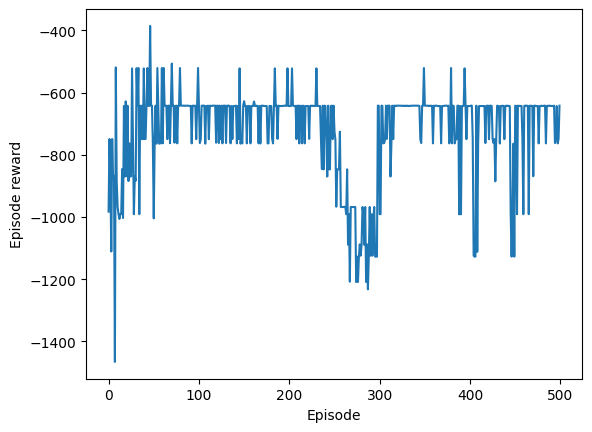

In [11]:
#Plot the rewards
from matplotlib import pyplot as plt

plt.plot(episode_rewards)
plt.ylabel('Episode reward')
plt.xlabel('Episode')
plt.show()


Plot other metrics from the info dictionary returned by the environment. For example, the number of times the agent charged or discharged the EVs.

array([<Axes: >, <Axes: >], dtype=object)

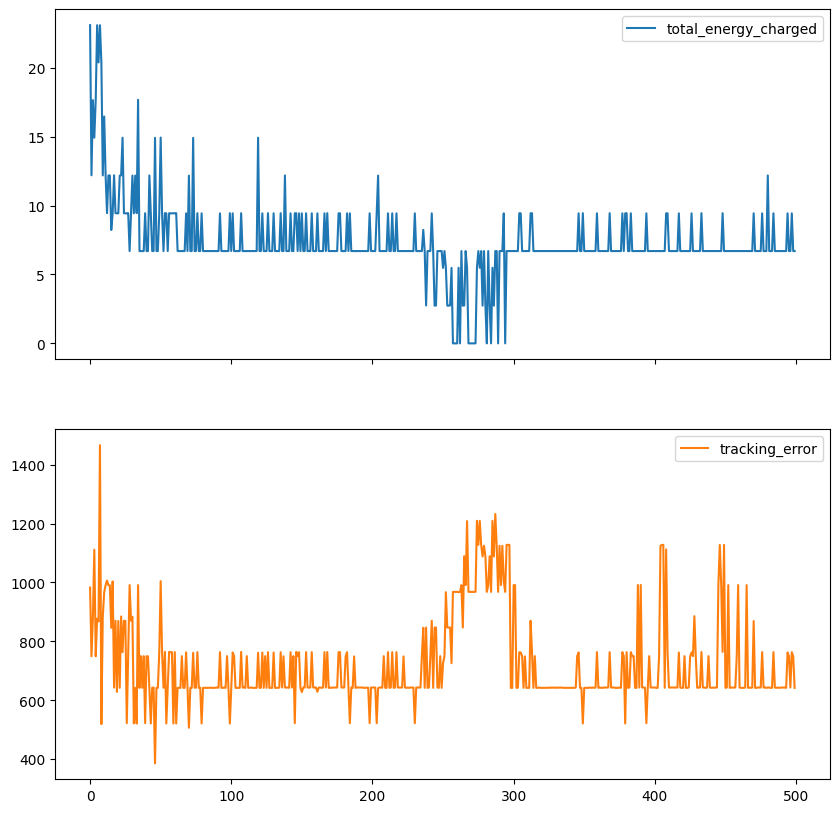

In [12]:
#plot episode stats
import pandas as pd
episode_stats = pd.DataFrame(episode_stats)
#Select only the columns we want to plot
episode_stats = episode_stats[['total_energy_charged','tracking_error']]

#plot
episode_stats.plot(subplots=True, figsize=(10,10))

